In [326]:
# basicas
import pandas as pd 
from datetime import date
import numpy as np 

# visualizaciones 
import seaborn as sns
import matplotlib.pyplot as plt 


# estacionariedad
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# pruebas de normalidad
from scipy.stats import shapiro, boxcox, anderson 
from statsmodels.stats.diagnostic import lilliefors

# prueba diferencia de medias 
import pingouin as pg

La hipotesis del presente trabajo de investigación se diseña con una comparación y se enuncia de la siguiente forma: 

* H0: No existen diferencias significativas entre la media de contagios de al menos 2 paises de America Latina en el año 2020 a un nivel de significancia del 0.5 %. 

* H1: Existen diferencias significativas entre la media de contagios de al menos 2 paises de America Latina a un nivel de significancia del 0.5%. 

In [21]:
df = pd.read_csv("C:/Users/URIEL/Documents/CURSO RSTUDIO/ANALISIS DE LOS DATOS DEL COVID19/covid_19_clean_complete.csv")

# Funciones

In [22]:
def tabla_frecuencias(df,col):
    rating_counts = (df.groupby(col).agg(frec_absoluta=(col, "count"))).sort_values(['frec_absoluta'], ascending = False)
    
    rating_counts["frec_absoluta_acumulada"] = rating_counts["frec_absoluta"].cumsum()

    
    rating_counts['frec_relativa'] = rating_counts['frec_absoluta'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())
    rating_counts['frec_relativa(%)'] = rating_counts['frec_relativa'].apply(lambda x: x*100 )

    
    
    rating_counts['frec_relativa_acumulada'] = rating_counts['frec_absoluta_acumulada'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())  
    rating_counts['frec_relativa_acumulada(%)'] = rating_counts['frec_relativa_acumulada'].apply(lambda x: x*100)
    
    return rating_counts

In [23]:
def pareto(df,col,Title):
    
    rating_counts = tabla_frecuencias(df,col)
    
    #diagrama pareto
    trace1 = go.Bar(
        x=[str(x) for x in rating_counts.index],
        y=rating_counts['frec_relativa(%)'],
        name='frec_relativa',
        marker=dict(
            color='rgb(34,163,192)'
                   )
    )
    trace2 = go.Scatter(
        x=[str(x) for x in rating_counts.index],
        y=rating_counts['frec_relativa_acumulada(%)'],
        name='fre_relativa_acumulada',
        yaxis='y2'

    )

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(trace1)
    fig.add_trace(trace2,secondary_y=True)
    fig['layout'].update(height = 600, width = 800, title =Title,xaxis=dict(
          tickangle=-90
        ))


    fig.show()

# Tratamiento

In [24]:
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,1/22/2020,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,1/22/2020,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,1/22/2020,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,1/22/2020,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,1/22/2020,0,0,0,0,Africa


In [25]:
# Valores Nulos 
(df.isnull().sum() / len(df)) * 100

Province/State    70.114943
Country/Region     0.000000
Lat                0.000000
Long               0.000000
Date               0.000000
Confirmed          0.000000
Deaths             0.000000
Recovered          0.000000
Active             0.000000
WHO Region         0.000000
dtype: float64

In [26]:
df.shape

(49068, 10)

**Estructura de los datos**


Es un dataframe, estructura basica, consta de 49069 observaciones, describe cada variable, tenemos 4 variables enteras, 3 caracter, etc. 

In [27]:
values = ["Provincia_Estado", "Pais_Region", "Latitud", "Longitud", "Fecha", "Casos_Confirmados", "Casos_Muertos", "Casos_Recuperados", 'Activos']

In [28]:
dict_from_list = dict(zip(df.columns, values))

In [29]:
df.rename(columns=dict_from_list, inplace = True)

In [30]:
df = pd.DataFrame(df.groupby(['Fecha','Pais_Region','Latitud','Longitud'])['Casos_Confirmados','Casos_Muertos','Casos_Recuperados','Activos'].sum()).reset_index()

<ipython-input-30-21da79ec3e6d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = pd.DataFrame(df.groupby(['Fecha','Pais_Region','Latitud','Longitud'])['Casos_Confirmados','Casos_Muertos','Casos_Recuperados','Activos'].sum()).reset_index()


In [31]:
df['year'] = pd.to_datetime(df['Fecha']).dt.to_period('Y')
df['month'] = pd.to_datetime(df['Fecha']).dt.month

fechas = df['year'].astype(str) + "-" + df['month'].astype(str) + "-" + '01'
df['Fecha_Mensual'] = pd.to_datetime(fechas)

In [32]:
df.head(5)

,Fecha,Pais_Region,Latitud,Longitud,Casos_Confirmados,Casos_Muertos,Casos_Recuperados,Activos,year,month,Fecha_Mensual
0,1/22/2020,Afghanistan,33.93911,67.709953,0,0,0,0,2020,1,2020-01-01
1,1/22/2020,Albania,41.15330,20.168300,0,0,0,0,2020,1,2020-01-01
2,1/22/2020,Algeria,28.03390,1.659600,0,0,0,0,2020,1,2020-01-01
3,1/22/2020,Andorra,42.50630,1.521800,0,0,0,0,2020,1,2020-01-01
4,1/22/2020,Angola,-11.20270,17.873900,0,0,0,0,2020,1,2020-01-01


con estadisticas basicas podemos observar que la media de muertos de manera general es de 884.179. 

Hay que ver si hay datos anómalos, datos incorrectos, mal escritos, mal desde la misma base de datos, podriamos decir que $$  Confirmados = Muertos + Recuperados + Enfermos$$ tendria el sentido calcular la columna de Enfermos, para poder usarlo en el análisis.

In [33]:
df['Enfermos'] = df['Casos_Confirmados'] - df['Casos_Muertos'] - df['Casos_Recuperados']

Vamos a filtrar si alguna fila tiene el numero de casos enfermos negativo, quiere decir que entre muertos y recuperados superan los casos confirmados. 

In [34]:
casos_raros = df[df['Enfermos'] < 0]

Podemos ver que hay si hay errores al respecto, por ejemplo, tenemos 
168 casos confirmados, 168 recuperados y 6 muertos dando un valor de -6 enfermos. 
entonces los 6 muertos estan sobrando o ¿Que paso con esos datos?. 

De momento hay varios lugares donde hay casos raros, por ejemplo: 

In [36]:
for value in casos_raros['Pais_Region'].unique():
    print(value)

China
United Kingdom
Liechtenstein
Uganda


In [37]:
df.loc[(df['Enfermos'] == '-6') & df['Pais_Region'] == 'China', 'Enfermos'] = 0

Hay datos donde no se puede hacer mas, porque no se tiene mas información al respecto. 
en el caso de arriba, se pudo hacer algo, ya que este si fue un error del mismo registro 
de los datos.

# Analisis Exploratorio
## Delimitación Geografica

### America

Delimitemos la información a los paises de America a traves de su latitud y longitud y veamos como estan los casos confirmados. 

In [141]:
paises_america = df[(((df['Latitud'] > -60) & (df['Latitud'] < 90)) & ((df['Longitud'] > -150) & (df['Longitud'] < -80))) & (df['Casos_Confirmados'] >= 0)]

In [142]:
paises_america = pd.DataFrame(paises_america.groupby(['Fecha','year','month','Fecha_Mensual','Pais_Region'])['Casos_Confirmados','Casos_Muertos','Casos_Recuperados','Activos'].sum()).reset_index()

<ipython-input-142-7740b472d9ee>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [143]:
paises_america = paises_america.sort_values(by=['Fecha'])

In [144]:
paises_america = paises_america.set_index('Fecha')

In [145]:
paises_america['Pais_Region'].unique()

array(['Belize', 'Canada', 'Costa Rica', 'El Salvador', 'Guatemala',
       'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'US',
       'United Kingdom'], dtype=object)

Se observa que en US es en donde mas Casos confirmados por COVID-19 existieron, 

In [148]:
casos_muertos = []
casos_recuperados = []
casos_enfermos = []
for pais in paises_america['Pais_Region'].unique():
    aux1 = df[(df['Pais_Region'] == pais)][['Casos_Muertos']].sum()[0] 
    aux2 = df[(df['Pais_Region'] == pais)][['Casos_Recuperados']].sum()[0]
    aux3 = df[(df['Pais_Region'] == pais)][['Enfermos']].sum()[0]
    casos_muertos.append(aux1)
    casos_recuperados.append(aux2)
    casos_enfermos.append(aux3)
    
    casos_muertos2 = dict(zip(paises_america.Pais_Region.unique(),casos_muertos))
    casos_recuperados2 = dict(zip(paises_america.Pais_Region.unique(),casos_recuperados))
    casos_enfermos2 = dict(zip(paises_america.Pais_Region.unique(),casos_enfermos))
    

Text(0.5, 1.0, 'Proporciones de Enfermos por COVID-19 en Paises de America en el año 2020. ')

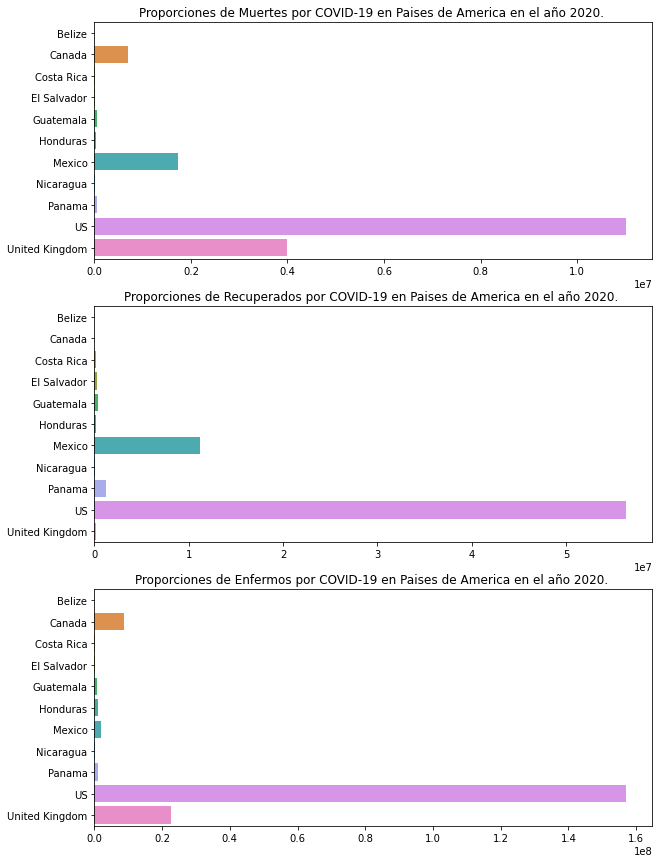

In [149]:
plt.figure(figsize = [10,20])

plt.subplot(411)
sns.barplot(x=list(casos_muertos2.values()) , y=list(casos_muertos2.keys()))
plt.title('Proporciones de Muertes por COVID-19 en Paises de America en el año 2020. ')

plt.subplot(412)    
sns.barplot(x=list(casos_recuperados2.values()) , y=list(casos_recuperados2.keys()))
plt.title('Proporciones de Recuperados por COVID-19 en Paises de America en el año 2020. ')

plt.subplot(413)    
sns.barplot(x=list(casos_enfermos2.values()) , y=list(casos_enfermos2.keys()))
plt.title('Proporciones de Enfermos por COVID-19 en Paises de America en el año 2020. ')

Conclusiones

Podemos Observar que US es el país en donde predominaron los Enfermos, Recuperados y Muertos por COVID-19, aunque en las Islas Cayman pertenecientes al Reino Unido, predominaron por debajo de US el número de muertos,México destaca en muertos y recuperados por COVID-19. 

<AxesSubplot:xlabel='Casos_Confirmados', ylabel='Pais_Region'>

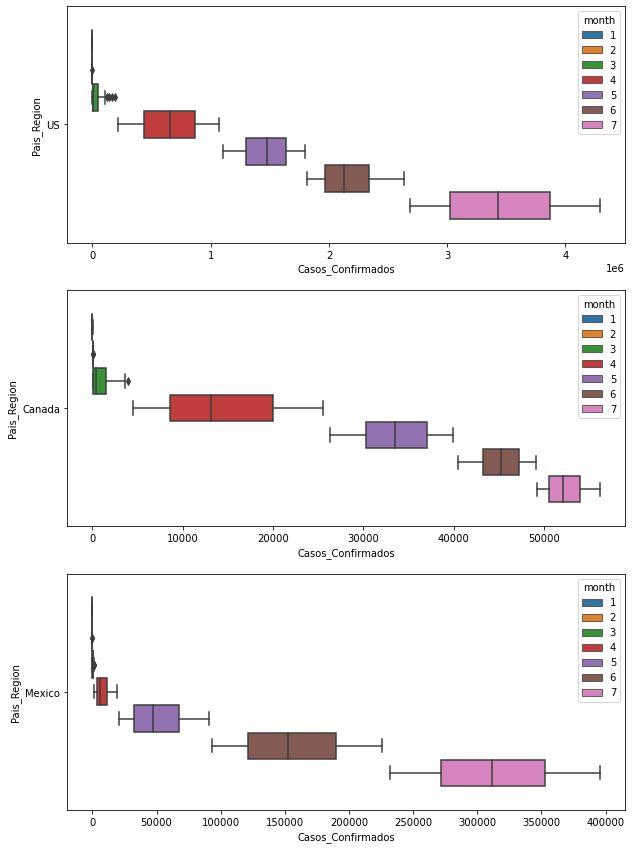

In [150]:

plt.figure(figsize = [10,20])

plt.subplot(411)
us = paises_america[(paises_america['Pais_Region'] == 'US')]
sns.boxplot(data = us, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')

plt.subplot(412)
canada = paises_america[(paises_america['Pais_Region'] == 'Canada')]
sns.boxplot(data = canada, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')

plt.subplot(413)
mx = paises_america[(paises_america['Pais_Region'] == 'Mexico')]
sns.boxplot(data = mx, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')



<AxesSubplot:xlabel='Casos_Confirmados', ylabel='Pais_Region'>

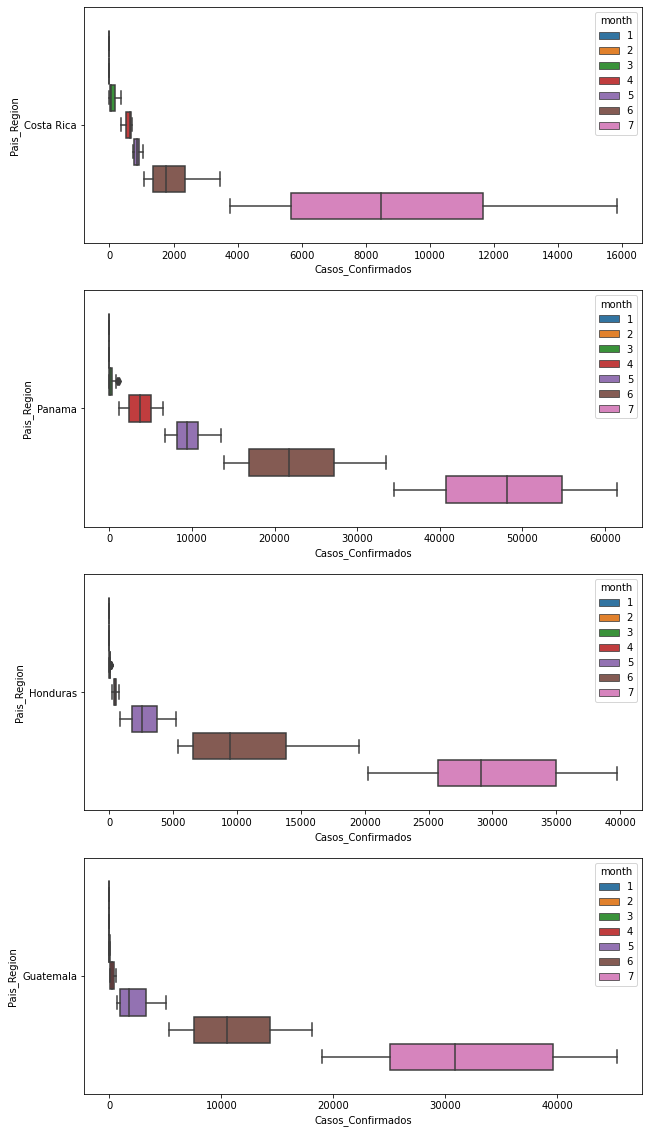

In [151]:
plt.figure(figsize = [10,20])

plt.subplot(411)
cr = paises_america[(paises_america['Pais_Region'] == 'Costa Rica')]
sns.boxplot(data = cr, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')

plt.subplot(412)
panama = paises_america[(paises_america['Pais_Region'] == 'Panama')]
sns.boxplot(data = panama, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')

plt.subplot(413)
honduras = paises_america[(paises_america['Pais_Region'] == 'Honduras')]
sns.boxplot(data = honduras, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')

plt.subplot(414)
guatemala = paises_america[(paises_america['Pais_Region'] == 'Guatemala')]
sns.boxplot(data = guatemala, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')

<AxesSubplot:xlabel='Casos_Confirmados', ylabel='Pais_Region'>

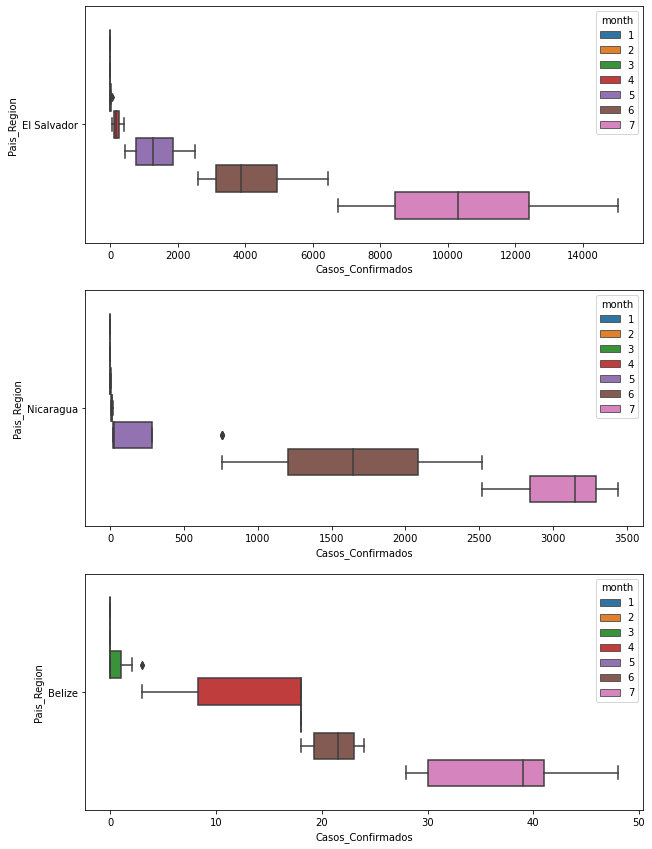

In [152]:
plt.figure(figsize = [10,20])


plt.subplot(411)
sv = paises_america[(paises_america['Pais_Region'] == 'El Salvador')]
sns.boxplot(data = sv, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')


plt.subplot(412)
nicaragua = paises_america[(paises_america['Pais_Region'] == 'Nicaragua')]
sns.boxplot(data = nicaragua, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')


plt.subplot(413)
belize = paises_america[(paises_america['Pais_Region'] == 'Belize')]
sns.boxplot(data = belize, x = 'Casos_Confirmados', y = 'Pais_Region', hue = 'month')

 Conclusion
 
 
 Los casos confirmados por COVID conforme los meses van pasando, van aumentando, es algo que evidentemente sucedió, la pandemia fue empeorando conforme el tiempo iba pasando, hasta antes de que llegará la vacuna. 

Se ve muy homogeneo y es algo esperado que en algunos paises como US, México o Canada hubiera los casos aumentaran de manera exponencial a comparación de otros paises de America. 

No hay mucho que destacar. 

In [153]:
paises_america_latina = paises_america[paises_america['Pais_Region'].isin(["Mexico",'Costa Rica','Panama', 'Honduras','Guatemala','El Salvador','Nicaragua',
                                      'Belize'])]

Text(0.5, 1.0, 'Casos Confirmados por COVID-19 de manera mensual durante el año 2020 en paises de America Latina ')

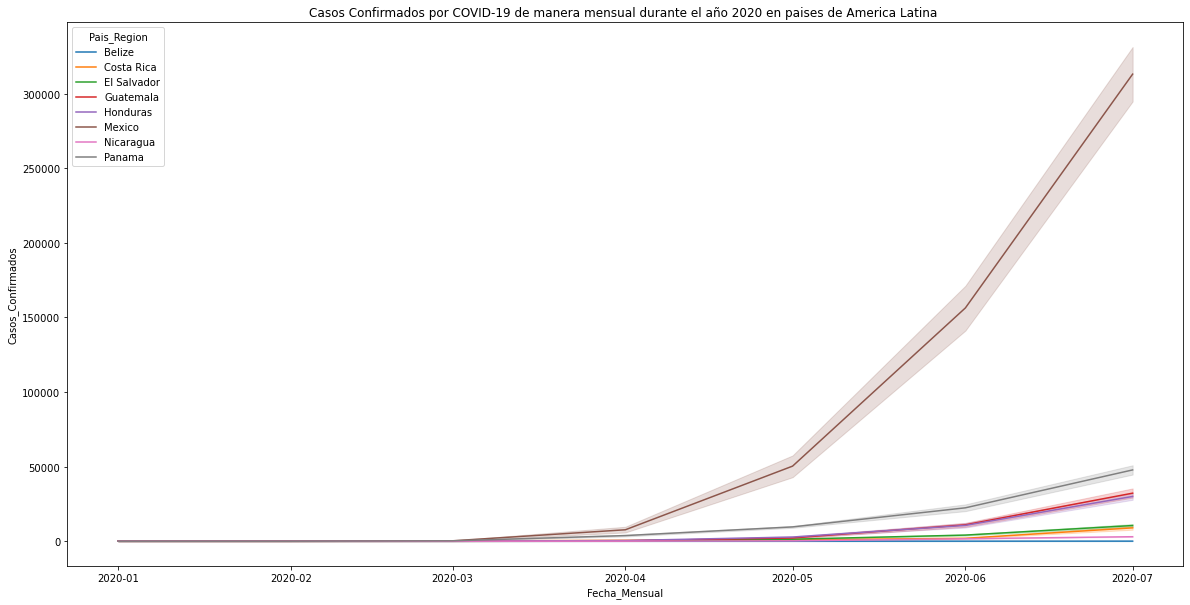

In [154]:
plt.figure(figsize = (20,10))
sns.lineplot(data=paises_america_latina, x="Fecha_Mensual", y="Casos_Confirmados", hue="Pais_Region")
plt.title('Casos Confirmados por COVID-19 de manera mensual durante el año 2020 en paises de America Latina ')

Text(0.5, 1.0, 'Casos Confirmados por COVID-19 de manera diaria durante el año 2020 en Paises de America Latina ')

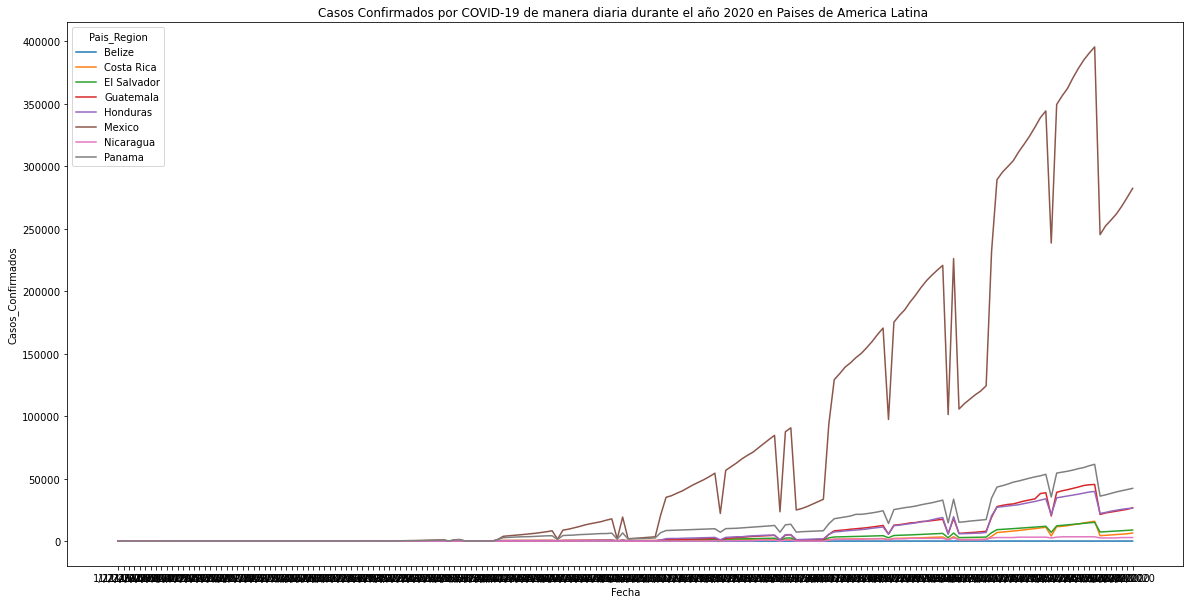

In [155]:
plt.figure(figsize = (20,10))
sns.lineplot(data=paises_america_latina, x="Fecha", y="Casos_Confirmados", hue="Pais_Region")
plt.title('Casos Confirmados por COVID-19 de manera diaria durante el año 2020 en Paises de America Latina ')

A simple viste se puede observar que las series correspondientes a los Casos Confirmados de Paises en America Latina, no son estacionarias. 

Aplicamos la prueba de Dickey Fuller a estas series No-Estacionarias

In [156]:
prueba = {}
for pais in paises_america_latina['Pais_Region'].unique():
    datos = paises_america_latina[paises_america_latina['Pais_Region'] == pais][['Casos_Confirmados']]
    
    prueba[pais] = adfuller(datos)
    p_value = prueba[pais][1]
    print(pais + ' :')
    print('El T-test es: ',prueba[pais][0])
    print('El P-Value es: ',prueba[pais][1])
    print('Valores Criticos: ',prueba[pais][4])
    if prueba[pais][1] < 0.05: 
        print('Desicion: Hay evidencia suficiente para rechazar H0, por lo tanto la Serie es Estacionaria')
    else:
        print('Desición:  No Hay evidencia suficiente para rechazar H0, por lo tanto la Serie es No-Estacionaria.')
    print('')

Belize :
El T-test es:  -0.5078147994014296
El P-Value es:  0.8904824475801782
Valores Criticos:  {'1%': -3.4680615871598537, '5%': -2.8781061899535128, '10%': -2.5756015922004134}
Desición:  No Hay evidencia suficiente para rechazar H0, por lo tanto la Serie es No-Estacionaria.

Costa Rica :
El T-test es:  0.05639656760526928
El P-Value es:  0.9629548642452707
Valores Criticos:  {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}
Desición:  No Hay evidencia suficiente para rechazar H0, por lo tanto la Serie es No-Estacionaria.

El Salvador :
El T-test es:  0.4722748283555133
El P-Value es:  0.9840056000614259
Valores Criticos:  {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}
Desición:  No Hay evidencia suficiente para rechazar H0, por lo tanto la Serie es No-Estacionaria.

Guatemala :
El T-test es:  0.24195077589334185
El P-Value es:  0.9745187357653019
Valores Criticos:  {'1%': -3.4674201432469816, '5%': -2.877826051844538

Dado que ninguna serie es Estacionaria, aplicaremos diferencias a los datos. 

Delimitaremos a solo tres paises de America Latina: Honduras, Panama y México. 

**CALCULAMOS DIFERENCIAS**

In [172]:
# Algoritmo que calcula las diferencias hasta que haya alguna donde podamos rechazar la hipotesis nula. 

i=1
botton = True
while botton == True:
    diff = 'diff'+str(i)
    diff_ = 'diff'+str(i-1)
    if i == 1:
        mx[diff] = mx['Casos_Confirmados'] - mx['Casos_Confirmados'].shift(1)
        panama[diff] = panama['Casos_Confirmados'] - panama['Casos_Confirmados'].shift(1)
        honduras[diff] = honduras['Casos_Confirmados'] - honduras['Casos_Confirmados'].shift(1)
    else:
        mx[diff] = mx[diff_] - mx[diff_].shift(1)
        panama[diff] = panama[diff_] - panama[diff_].shift(1)
        honduras[diff] = honduras[diff_] - honduras[diff_].shift(1)
        
    mx = mx.dropna(subset=[diff])         
    panama = panama.dropna(subset=[diff])         
    honduras = honduras.dropna(subset=[diff])  
        
    u1 = adfuller(mx[diff])
    u2 = adfuller(panama[diff])
    u3 = adfuller(honduras[diff])
    
    
    if  u1[1] < 0.05 or u2[1] < 0.05 or u3 < 0.05:
        print('Desicion: Hay evidencia suficiente para rechazar H0, por lo tanto las tres Series son Estacionarias')
        print('Diferencia '+str(i))
        print('P-Value de la serie de Mexico: '+str(u1[1]))
        print('P-Value de la serie de Panama: '+str(u2[1]))
        print('P-Value de la serie de Honduras: '+str(u3[1]))               
        botton=False
    
    i+=1   

Desicion: Hay evidencia suficiente para rechazar H0, por lo tanto las tres Series son Estacionarias
Diferencia 1
P-Value de la serie de Mexico: 0.0
P-Value de la serie de Panama: 0.0
P-Value de la serie de Honduras: 0.0


<ipython-input-172-5c36f805cffd>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



En la primer diferencia, se pudo lograr hacer que las series fueran ya Estacionarias.

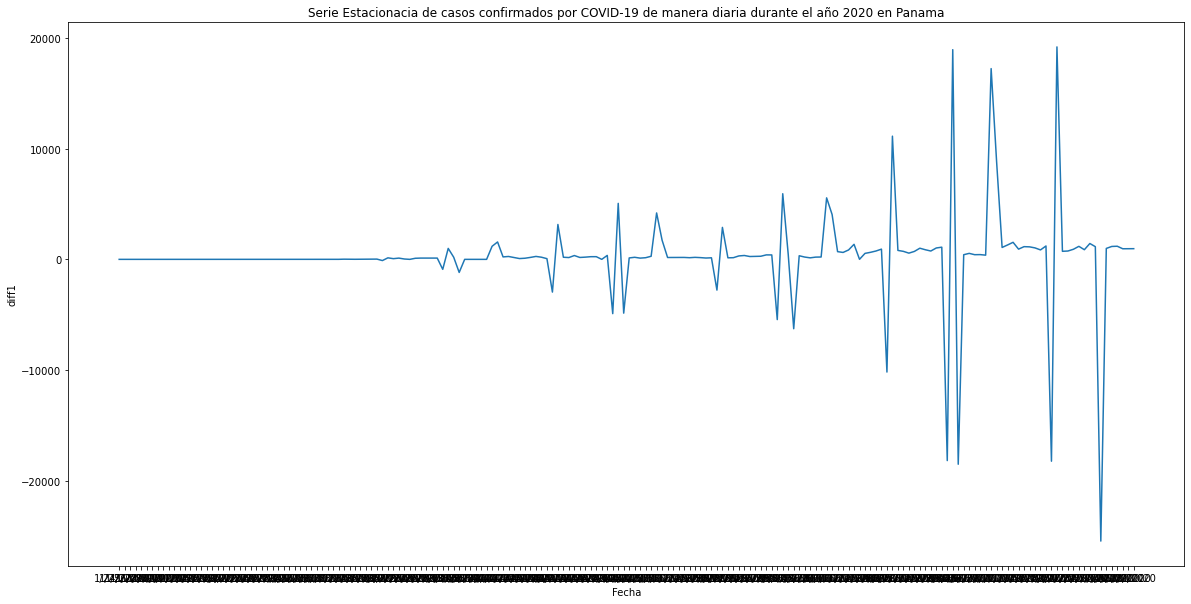

In [368]:
plt.figure(figsize = (20,10))
sns.lineplot(data=panama, x="Fecha", y="diff1")
plt.title('Serie Estacionacia de casos confirmados por COVID-19 de manera diaria durante el año 2020 en Panama')
plt.show()

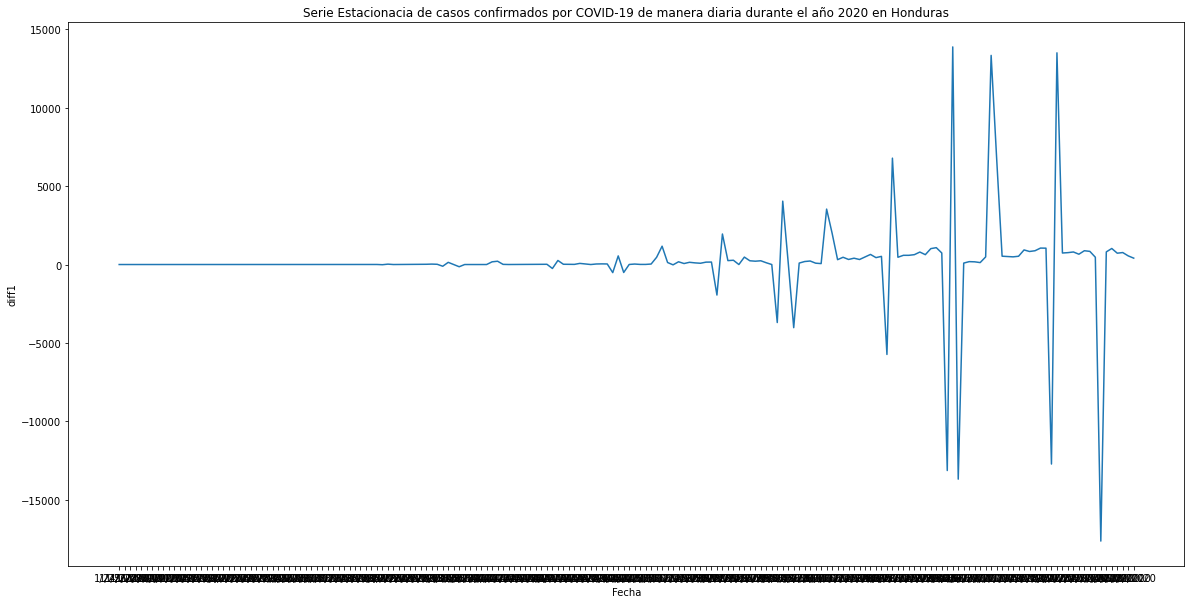

In [369]:
plt.figure(figsize = (20,10))
sns.lineplot(data=honduras, x="Fecha", y="diff1")
plt.title('Serie Estacionacia de casos confirmados por COVID-19 de manera diaria durante el año 2020 en Honduras')
plt.show()

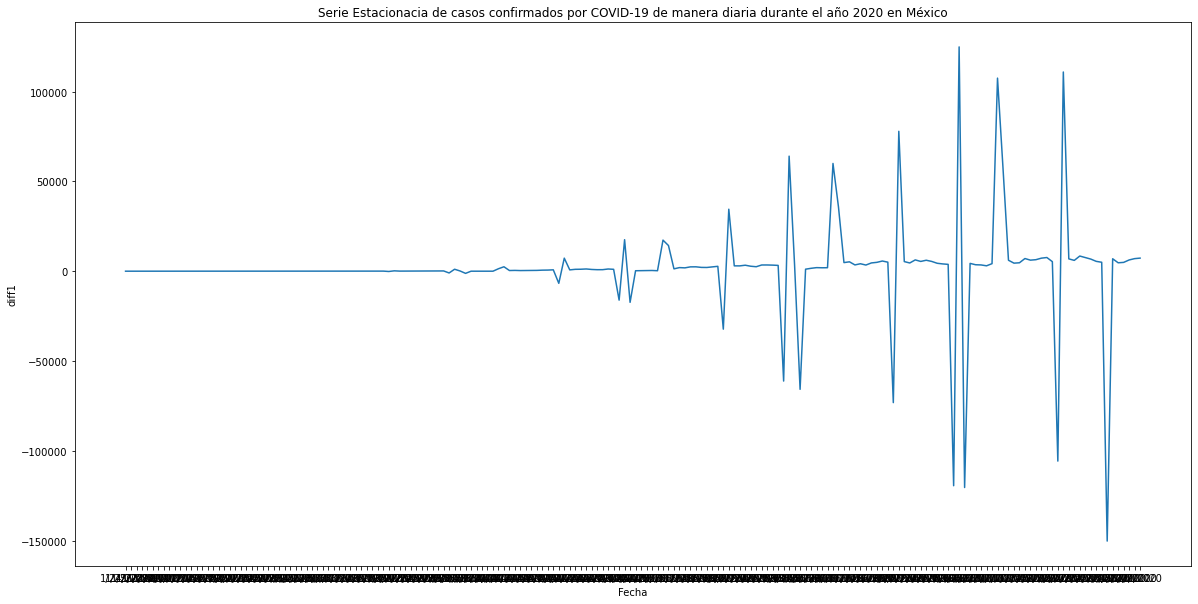

In [370]:
plt.figure(figsize = (20,10))
sns.lineplot(data=mx, x="Fecha", y="diff1")
plt.title('Serie Estacionacia de casos confirmados por COVID-19 de manera diaria durante el año 2020 en México')
plt.show()

Series de Tiempos Estacionarias para México, Panama y Honduras

Antes de aplicar pruebas de hipotesis e Intervalos de Confianza hay que asegurarnos de que los datos son Normales. 

### Pruebas de Normalidad

La normalidad consiste en que todas las muestras, tienen que estar distribuidas normalmente, es decir cumplir con la distribución normal, existen diferentes metodos para comprobar la normalidad. 

**Graficos Q-Q**

Text(0.5, 1.0, 'Panama')

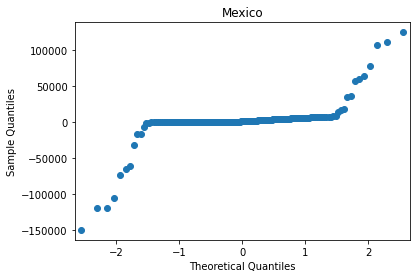

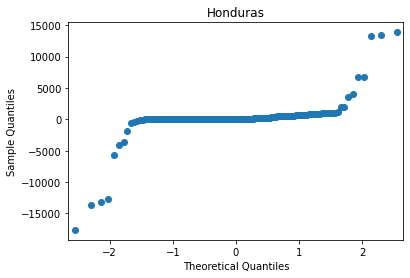

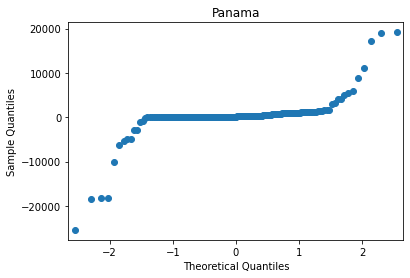

In [209]:
sm.qqplot(mx['diff1'])
plt.title('Mexico')

sm.qqplot(honduras['diff1'])
plt.title('Honduras')

sm.qqplot(panama['diff1'])
plt.title('Panama')

Aplicando el primer metodo para probar Normalidad, detectamos que los datos No Son Normales. 

Transformaremos los datos con una prueba Box-Cox para "obligarlos" a que se vuelvan Normales. 

In [349]:
transform_data_mx, best_lambda = boxcox(mx[mx['diff1'] > 0]['diff1'])

transform_data_ho, best_lambda = boxcox(honduras[honduras['diff1'] > 0]['diff1'])

transform_data_pa, best_lambda = boxcox(panama[panama['diff1'] > 0]['diff1'])

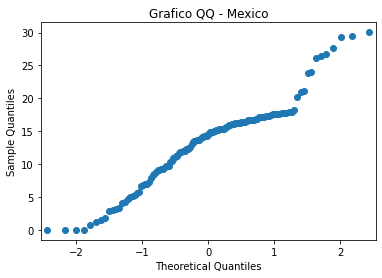

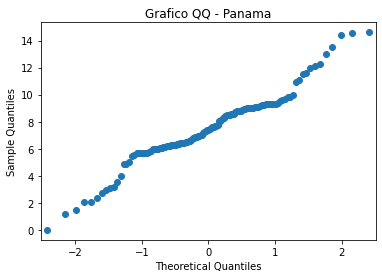

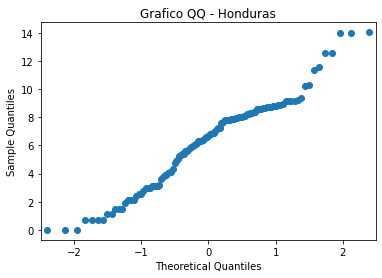

In [350]:
sm.qqplot(transform_data_mx, color = 'r')
plt.title('Grafico QQ - Mexico')
plt.show()


sm.qqplot(transform_data_pa, color = 'b')
plt.title('Grafico QQ - Panama')
plt.show()

sm.qqplot(transform_data_ho,color = 'g')
plt.title('Grafico QQ - Honduras')
plt.show()


Al aplicar nuevamente la prueba QQ-Plot se observa que los datos ya presentan tendencia de ajuste a los Quantiles teóricos de una distribución Normal

**Graficos de frecuencia y densidad**

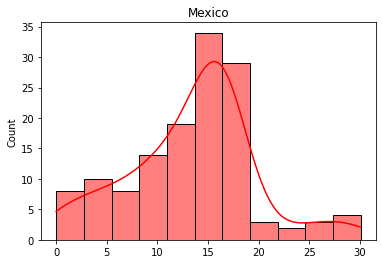

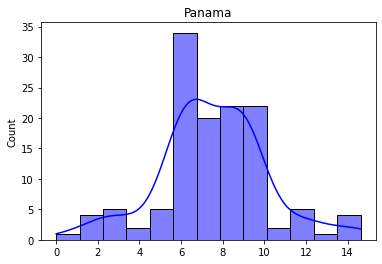

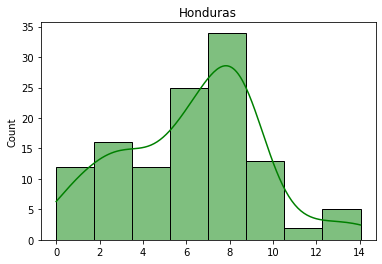

In [351]:
sns.histplot(data = transform_data_mx, kde = True, color = 'r')
plt.title('Mexico')
plt.show()

sns.histplot(data = transform_data_pa, kde = True, color = 'b')
plt.title('Panama')
plt.show()

sns.histplot(data = transform_data_ho, kde = True, color = 'g')
plt.title('Honduras')
plt.show()

Viendo los gráficos se puede observar que se estan forzando a poder ajustarse a una distribución normal.

**Tests De Normalidad**



In [352]:
datos = {'Mexico':transform_data_mx, 'Panama': transform_data_pa, 'Honduras': transform_data_ho}


In [354]:
# Shapiro Wilks

for pais in datos.keys():
    p_value = shapiro(datos[pais])[1]
    
    print(pais)
    print('p-value: '+str(p_value))
    if p_value < 0.05:
        print('Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal')
    else:
        print('No Hay evidencia suficiente para rechazar la hipotesis nula, los datos no provienen de una distribución normal.')
    print('')

Mexico
p-value: 0.00020434882026165724
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal

Panama
p-value: 0.0031503860373049974
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal

Honduras
p-value: 0.004653688054531813
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal



In [355]:
# Anderson - Darlin

for pais in datos.keys():
    critical_values = anderson(datos[pais])[1]
    statistic = anderson(datos[pais])[0]
    evaluation = [x for x in critical_values if x < statistic ]
    
    print(pais)
    print('statistic: '+ str(statistic))
    if len(evaluation)  == len(critical_values):
        print('Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal')
    else:
        print('No Hay evidencia suficiente para rechazar la hipotesis nula, los datos no provienen de una distribución normal.')
    print('')

Mexico
statistic: 2.3584293556033344
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal

Panama
statistic: 1.549162813517512
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal

Honduras
statistic: 1.4426387709432333
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal



In [356]:
# lilliefors

for pais in datos.keys():
    statisctic, p_value = lilliefors(datos[pais])

    print(pais)
    print('statistic: '+ str(statistic))
    print('p-value: '+ str(p_value))    
    if p_value <= 0.05:
        print('Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal')
    else:
        print('No Hay evidencia suficiente para rechazar la hipotesis nula, los datos no provienen de una distribución normal.')
    print('')

Mexico
statistic: 1.4426387709432333
p-value: 0.0009999999999998899
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal

Panama
statistic: 1.4426387709432333
p-value: 0.0027033092509077235
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal

Honduras
statistic: 1.4426387709432333
p-value: 0.01657984751724663
Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto los datos provienen de una distribución normal



Con un nivel de significancia del 0.05 se dice que existe suficiente evidencia estadistica para no rechazar H0, pues los valores de p-value para las pruebas de Shapiro-Wilks, Anderson-Darlin y lilliefors  son mayores al nivel de significancia.

Los datos de los Casos Confirmados de Mexico, Panama y Honduras, despues de aplicarle la transformación de Box-Cox se ajustan a una distribución normal. 

Podemos aplicar pruebas de hipotesis e intervalos de confianza

# Pruebas de Hipotesis Parametricas 

* Sea $X$ = Casos Confirmados de COVID-19 en México en el año 2020.
* Sea $Y$ = Casos Confirmados de COVID-19 en Panama en el años 2020. 
* Sea $Z$ = Casos Confirmados de COVID-19 en Honduras en el años 2020. 

In [357]:
X = datos['Mexico']
Y = datos['Panama']
Z = datos['Honduras']

* H0
 : no hay diferencia entre las medias poblacionales:  $\mu$(Casos confirmados en Mexico)−$\mu$(Casos Confirmados en Panama)=0
 
* H1
 : si hay diferencia entre las medias poblacionales:   $\mu$(Casos confirmados en Mexico)−$\mu$(Casos Confirmados en Panama)≠0
 

In [358]:
pg.ttest(x=X, y=Y, alternative='two-sided', correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.716839,259,two-sided,3.134305e-19,"[4.66, 7.02]",1.203347,1.29e+16,1.0


Dado que el p-value = 1.005779e-23 < 0.05 = significancia, Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto si podemos considerar que existió una diferencia real entre los casos promedios confirmados en México y los casos promedios confirmados en Panama en el año 2020.

* H0
 : no hay diferencia entre las medias poblacionales:  $\mu$(Casos confirmados en Mexico)−$\mu$(Casos Confirmados en Honduras)=0
 
* H1
 : si hay diferencia entre las medias poblacionales:   $\mu$(Casos confirmados en Mexico)−$\mu$(Casos Confirmados en Honduras
 )≠0

In [359]:
pg.ttest(x=X, y=Z, alternative='two-sided', correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,11.152136,251,two-sided,1.005779e-23,"[5.85, 8.36]",1.404729,3.079e+20,1.0


Dado que el p-value = 	1.005779E-23 < 0.05 = significancia, Hay evidencia suficiente para rechazar la hipotesis nula, por lo tanto si podemos considerar que existió una diferencia real entre los casos promedios confirmados en México y los casos promedios confirmados en Honduras en el año 2020.

* H0
 : no hay diferencia entre las medias poblacionales:  $\mu$(Casos confirmados en Panama)−$\mu$(Casos Confirmados en Honduras)=0
 
* H1
 : si hay diferencia entre las medias poblacionales:   $\mu$(Casos confirmados en Panama)−$\mu$(Casos Confirmados en Honduras)≠0

In [360]:
pg.ttest(x=Y, y=Z, alternative='two-sided', correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.41375,244,two-sided,0.00075,"[0.53, 1.99]",0.435536,31.681,0.925112


Dado que el p-value = 	0.00075 < 0.05 = significancia, Hay evidencia suficiente para  rechazar la hipotesis nula, por lo tanto si podemos considerar que existió una diferencia real entre los casos promedios confirmados en Panama y los casos promedios confirmados en Honduras en el año 2020.

# Intervalos de Confianza

In [361]:
def intervalo_confianza_normal(data = False, data2=False, alpha=0.05, mu=False, sigma=False):
    from scipy.stats import t,chi2,f
    import numpy as np 

    media_muestral = np.mean(data)
    desv_muestral = np.std(data)
    grados_libertad = len(data)-1
    n = len(data)
    p = str
    inf_ = str
    sup_ = str

    #Intervalo de confianza para la media de una poblacion normal con varianza desconocida 
    if (mu is True) and (sigma is False) and (data2 is False):
        p = 'media poblacional'
        t_student = t(grados_libertad).ppf(1-(alpha/2))
        sup_ = media_muestral + (t_student * (desv_muestral/np.sqrt(n)))
        inf_ = media_muestral - (t_student * (desv_muestral/np.sqrt(n)))
        
    #Intervalo de confianza para la varianza de una población normal con media desconocida. 
    elif (mu is False) and (sigma is True) and (data2 is False):
        p = 'varianza poblacional'
        chi2_sup = chi2(grados_libertad).ppf(alpha / 2)
        chi2_inf = chi2(grados_libertad).ppf(1-(alpha/2))
        sup_ = ((n-1)*desv_muestral**2) / chi2_sup
        inf_ = ((n-1)*desv_muestral**2) / chi2_inf
        
        
    #Intervalo de confianza para la diferencia de medias de dos poblaciones normales independientes.
    elif (data is not False) and (data2 is not False):
        x_mean = np.mean(data)
        y_mean = np.mean(data2)
        n1 = len(data)
        n2 = len(data2)
        s1_2 = np.std(data)**2
        s2_2 = np.std(data2)**2
        
        # Caso 1. Suponiendo varianzas desconocidas pero iguales. 
        if (mu is True) and (sigma is False):
            p = 'diferencia de medias poblacionales'
            sp_2 = (((n1-1)*(s1_2))+((n2-1)*(s2_2))) / (n1+n2-2)
            sp = np.sqrt(sp_2)
            t_student = t(n1+n2-2).ppf(1-(alpha/2))
            sup_ = (x_mean - y_mean) + (t_student * sp * (np.sqrt((1/n1)+(1/n2))))
            inf_ = (x_mean - y_mean) - (t_student * sp * (np.sqrt((1/n1)+(1/n2))))
            
        # Caso 2. Suponiendo varianzas desconocidas y no iguales
        
        # Caso 3. Intervalo de confianza para la razon de varianzas en poblaciones normales. 
        elif (mu is False) and (sigma is True):
            p = 'razon de varianzas poblacionales'
            fisher_inf = f(n1-1,n2-1).ppf(alpha/2)
            fisher_sup = f(n1-1,n2-1).ppf(1-(alpha/2))
            s1_2_s2_2 = s1_2 / s2_2
            sup_ = s1_2_s2_2 * fisher_sup
            inf_ = s1_2_s2_2 * fisher_inf
            
            
    print('Intervalo de confianza al {}% para la {}: '.format(int(100 * (1-alpha)),p))
    print('[{},{}]'.format(inf_,sup_))

In [362]:
intervalo_confianza_normal(data = X , data2=False, alpha=0.05, mu=True, sigma=False)

Intervalo de confianza al 95% para la media poblacional: 
[12.290868071560045,14.427114077979574]


In [363]:
intervalo_confianza_normal(data = Y , data2=False, alpha=0.05, mu=True, sigma=False)

Intervalo de confianza al 95% para la media poblacional: 
[7.059808936861324,7.976683669291645]


In [364]:
intervalo_confianza_normal(data = Z , data2=False, alpha=0.05, mu=True, sigma=False)

Intervalo de confianza al 95% para la media poblacional: 
[5.686524977353244,6.8289442048326165]
